# Using pre-trained NN

In [1]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from imageio import imread
import pickle
import pandas as pd

Using TensorFlow backend.


In [ ]:
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [2]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten # You may need this :)

In [3]:
img_input = Input(shape=(224, 224, 3), name="input")


conv1_1 = Conv2D(64, 3, padding="same", name="conv1_1", activation="relu")(img_input)
conv1_2 = Conv2D(64, 3, padding="same", name="conv1_2", activation="relu")(conv1_1)
pool1   = MaxPool2D(strides=2, padding="same", name="pool1")(conv1_2)

conv2_1 = Conv2D(128, 3, padding="same", name="conv2_1", activation="relu")(pool1)
conv2_2 = Conv2D(128, 3, padding="same", name="conv2_2", activation="relu")(conv2_1)
pool2   = MaxPool2D(strides=2, padding="same", name="pool2")(conv2_2)

conv3_1 = Conv2D(256, 3, padding="same", name="conv3_1", activation="relu")(pool2)
conv3_2 = Conv2D(256, 3, padding="same", name="conv3_2", activation="relu")(conv3_1)
conv3_3 = Conv2D(256, 3, padding="same", name="conv3_3", activation="relu")(conv3_2)
pool3   = MaxPool2D(strides=2, padding="same", name="pool3")(conv3_3)

conv4_1 = Conv2D(512, 3, padding="same", name="conv4_1", activation="relu")(pool3)
conv4_2 = Conv2D(512, 3, padding="same", name="conv4_2", activation="relu")(conv4_1)
conv4_3 = Conv2D(512, 3, padding="same", name="conv4_3", activation="relu")(conv4_2)
pool4   = MaxPool2D(strides=2, padding="same", name="pool4")(conv4_3)

conv5_1 = Conv2D(512, 3, padding="same", name="conv5_1", activation="relu")(pool4)
conv5_2 = Conv2D(512, 3, padding="same", name="conv5_2", activation="relu")(conv5_1)
conv5_3 = Conv2D(512, 3, padding="same", name="conv5_3", activation="relu")(conv5_2)
pool5   = MaxPool2D(strides=2, padding="same", name="pool5")(conv5_3)

flatten = Flatten()(pool5)

fc6     = Dense(4096, activation="relu", name="fc6")(flatten)
drop1   = Dropout(0.5)(fc6)

fc7     = Dense(4096, activation="relu", name="fc7")(drop1)
drop2   = Dropout(0.5)(fc7)

fc8     = Dense(1000, activation="relu", name="fc8")(drop2)

output  = Activation("softmax", name="prob")(fc8)

model = keras.Model(img_input, output)

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 224, 224, 3). Without this transformation, vgg16 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [4]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1].astype(np.float64)
    for i in range(3):
        img[:,:,i] -= MEAN_VALUES[i]
        
    # convert from [w,h,3 to 1,w,h,3]
    return img[None]

def deprocess(img):
    img = img.reshape(img.shape[1:])
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [5]:
# load vgg16 weights
import h5py
with h5py.File("vgg16_weights_tf_dim_ordering_tf_kernels.h5", "r") as f:
    vgg16_weights = {k1: {k2:v2.value for k2, v2 in v1.items()} 
                     for k1, v1 in f.items() if len(v1)>0}

Now we should put the weights into their places:

In [6]:
weightKeys = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 
              'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 
              'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2',
              'block5_conv3', 'fc1',  'fc2', 'predictions']

In [7]:
weights = [[vgg16_weights[x][x+"_W_1:0"], vgg16_weights[x][x+"_b_1:0"]] for x in weightKeys]

In [9]:
layers = [1,2,4,5,7,8,9,11,12,13,15,16,17,20,22,24]

In [10]:
for i,w in zip(layers, weights):
    model.layers[i].set_weights(w)

In [11]:
# classes' names are stored here
with open("classes.txt", "r") as f:
    classes = f.read().splitlines()
# for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


### Sanity check
Lets check that out pretrained network is working. We have sample image of a "albatross" and lets check that out network predicts it well.

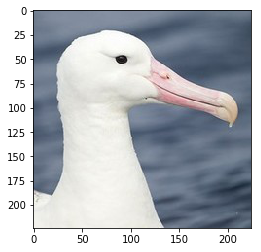

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [12]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()

p = model.predict(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

In [13]:
genFeatures = keras.Model(img_input, fc6)

In [18]:
#extract features from images
from tqdm import tqdm
from skimage.transform import resize as imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W), preserve_range=True))
    features = genFeatures.predict(img)
    Y.append(y)
    X.append(features)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [3:02:06<00:00,  2.29it/s]


In [19]:
X = np.concatenate(X)
Y = Y[:len(X)]

In [20]:
pickle.dump(X, open("X.pkl",'wb'))
pickle.dump(Y, open("Y.pkl",'wb'))

In [14]:
X = np.asarray(pickle.load(open("X.pkl",'rb')))
Y = np.asarray(pickle.load(open("Y.pkl",'rb')))

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, Y_val = train_test_split(X_train,y_train, test_size=0.25)

C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [111]:
X_real_test = np.zeros([12500,4096])
for fname in tqdm(os.listdir('test/')):
    img = imread("test/" + fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W), preserve_range=True))
    X_real_test[int(fname[:-4])-1] = genFeatures.predict(img)

  0%|                                                                                        | 0/12500 [00:00<?, ?it/s]C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [1:35:46<00:00,  2.18it/s]


In [122]:
pickle.dump(X_real_test, open("X_test.pkl",'wb'))

In [36]:
X_real_test = np.asarray(pickle.load(open("X_test.pkl",'rb')))

In [54]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import keras.optimizers as opts
from keras import losses
from sklearn.metrics import average_precision_score
from keras import regularizers

In [55]:
(X_train.shape, X_val.shape, X_test.shape)

((15000, 4096), (5000, 4096), (5000, 4096))

In [70]:
inpt = Input(shape=(4096,), name="in")

l1     = Dense(2000, activation="relu", name="l1", kernel_regularizer=regularizers.l2(0.01))(inpt)
drop0   = Dropout(0.5)(l1)

l2     = Dense(1000, activation="relu", name="l2")(drop0)
drop1   = Dropout(0.5)(l2)

l3     = Dense(100, activation="relu", name="l3")(drop1)

output = Dense(1, activation="sigmoid", name="out")(l3)

mymodel = keras.Model(inpt, output)

In [71]:
opt = opts.Adam()
mymodel.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['accuracy'])
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 4096)              0         
_________________________________________________________________
l1 (Dense)                   (None, 2000)              8194000   
_________________________________________________________________
dropout_19 (Dropout)         (None, 2000)              0         
_________________________________________________________________
l2 (Dense)                   (None, 1000)              2001000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1000)              0         
_________________________________________________________________
l3 (Dense)                   (None, 100)               100100    
_________________________________________________________________
out (Dense)                  (None, 1)                 101       
Total para

In [72]:
history = mymodel.fit(X_train, y_train, epochs=20 ,batch_size=200,
                      validation_data=(X_val, Y_val))

Train on 15000 samples, validate on 5000 samples
Epoch 1/20
15000/15000 [==============================] - 23s 2ms/step - loss: 17.6206 - acc: 0.4999 - val_loss: 10.1288 - val_acc: 0.5004
Epoch 2/20
15000/15000 [==============================] - 21s 1ms/step - loss: 8.9509 - acc: 0.5004 - val_loss: 8.3513 - val_acc: 0.5004
Epoch 3/20
15000/15000 [==============================] - 21s 1ms/step - loss: 5.7204 - acc: 0.6641 - val_loss: 1.6345 - val_acc: 0.9818
Epoch 4/20
15000/15000 [==============================] - 21s 1ms/step - loss: 0.7254 - acc: 0.9811 - val_loss: 0.3043 - val_acc: 0.9848
Epoch 5/20
15000/15000 [==============================] - 21s 1ms/step - loss: 0.2462 - acc: 0.9834 - val_loss: 0.2238 - val_acc: 0.9776
Epoch 6/20
15000/15000 [==============================] - 22s 1ms/step - loss: 0.2098 - acc: 0.9822 - val_loss: 0.2034 - val_acc: 0.9796
Epoch 7/20
15000/15000 [==============================] - 21s 1ms/step - loss: 0.1851 - acc: 0.9824 - val_loss: 0.1785 - val_ac

In [73]:
pred = mymodel.predict(X_test)

In [74]:
average_precision_score(y_test, pred)

0.9987170897227021

In [137]:
history = mymodel.fit(X, Y, epochs=20 ,batch_size=200)

Epoch 1/20
25000/25000 [==============================] - 34s 1ms/step - loss: 0.1427 - acc: 0.9819
Epoch 2/20
25000/25000 [==============================] - 34s 1ms/step - loss: 0.1442 - acc: 0.9829
Epoch 3/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1381 - acc: 0.9830
Epoch 4/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1307 - acc: 0.9827
Epoch 5/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1285 - acc: 0.9836
Epoch 6/20
25000/25000 [==============================] - 31s 1ms/step - loss: 0.1399 - acc: 0.9829
Epoch 7/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1357 - acc: 0.9828
Epoch 8/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1306 - acc: 0.9836
Epoch 9/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1322 - acc: 0.9832
Epoch 10/20
25000/25000 [==============================] - 32s 1ms/step - loss: 0.1285 - acc: 0.9828

In [142]:
mymodel.save_weights("NN_weight")

In [138]:
pred = mymodel.predict(X_real_test)

In [139]:
df = 1 - pd.DataFrame(pred)

In [140]:
df.index = pd.RangeIndex(1, 12501, 1, name="id")
df.columns = ["label"]

In [141]:
df.to_csv("submission.csv")

In [148]:
from IPython.display import Image

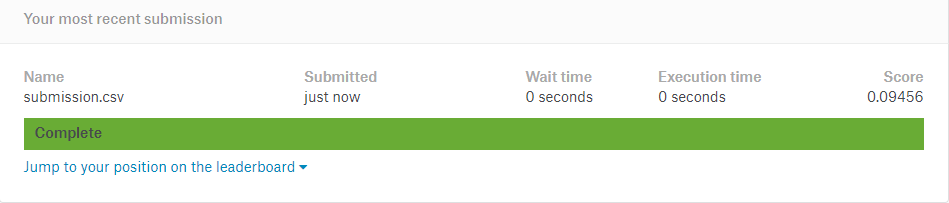

In [150]:
Image(filename="kaggle.png")